In [ ]:
# Evaluación y Comparación de Modelos
# Compararemos dos enfoques para detectar fraudes:
# - Modelo base: Regresión logística
# - Modelo avanzado: Red neuronal densa

In [1]:
# 1. Importar librerías y módulos del proyecto
import os
import sys
sys.path.append("../src")

import train
import yaml
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from utils import get_training_data_path, plot_f1_vs_threshold, plot_prediction_distribution
from utils import plot_confusion_matrix, get_classification_metrics_df
from utils import plot_ks_overtraining

In [2]:
# 2. Cargar configuración y datos
config = train.load_config()
train_path = get_training_data_path(config)
X_train, y_train = train.load_data(train_path, config["base_dir"])
X_test, y_test = train.load_data(config["paths"]["test"], config["base_dir"])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
# 3. Entrenar modelo base (regresión logística)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:, 1]

In [4]:
# 4. Cargar red neuronal ya entrenada
model_path = os.path.join(config["base_dir"], "models", "model.keras")
nn_model = load_model(model_path)

y_prob_nn = nn_model.predict(X_test_scaled).flatten()
y_prob_train_nn = nn_model.predict(X_train_scaled).flatten()

threshold = 0.5 #was 0.95
y_pred_nn = (y_prob_nn > threshold).astype(int)

6231/6231 [==============================] - 16s 3ms/step


In [5]:
from sklearn.metrics import f1_score
import numpy as np

# Generar array de posibles thresholds
thresholds = np.arange(0.0, 1.0, 0.01)

# Evaluar F1-score para cada threshold
f1_scores = [f1_score(y_test, (y_prob_nn > t).astype(int)) for t in thresholds]

# Obtener el mejor threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"✅ Mejor threshold: {best_threshold:.2f} con F1-score: {best_f1:.4f}")

# Recalcular predicciones con el mejor threshold
y_pred_nn_best = (y_prob_nn > best_threshold).astype(int)


✅ Mejor threshold: 0.99 con F1-score: 0.8000


In [6]:
# 5. Comparar métricas
print("🔎 Regressión Logística")
print(classification_report(y_test, y_pred_log, target_names=["No Fraude", "Fraude"]))
print("AUC:", roc_auc_score(y_test, y_prob_log))

print("\n🔬 Red Neuronal (threshold optimizado)")
print(classification_report(y_test, y_pred_nn_best, target_names=["No Fraude", "Fraude"]))
print("AUC:", roc_auc_score(y_test, y_prob_nn)) 

🔎 Regressión Logística
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     42648
      Fraude       0.92      0.64      0.75        74

    accuracy                           1.00     42722
   macro avg       0.96      0.82      0.88     42722
weighted avg       1.00      1.00      1.00     42722

AUC: 0.9564594138313891

🔬 Red Neuronal (threshold optimizado)
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00     42648
      Fraude       0.79      0.81      0.80        74

    accuracy                           1.00     42722
   macro avg       0.89      0.91      0.90     42722
weighted avg       1.00      1.00      1.00     42722

AUC: 0.9751328600688478


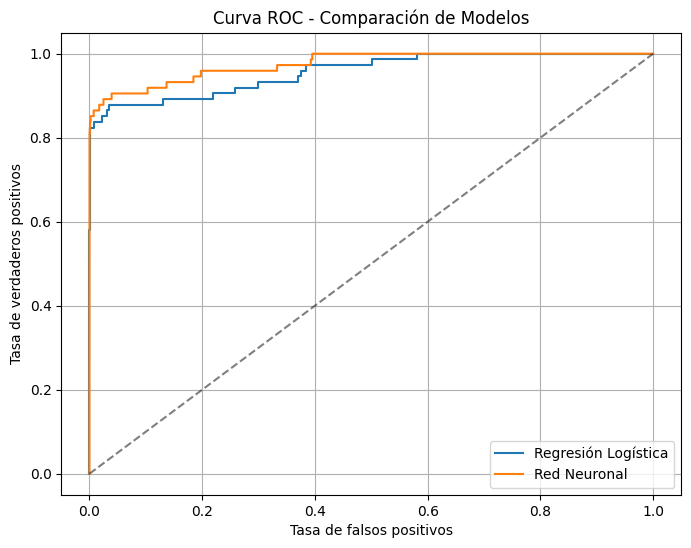

In [7]:
# 6. Comparar curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label="Regresión Logística")
plt.plot(fpr_nn, tpr_nn, label="Red Neuronal")
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC - Comparación de Modelos")
plt.legend()
plt.grid()
plt.show()

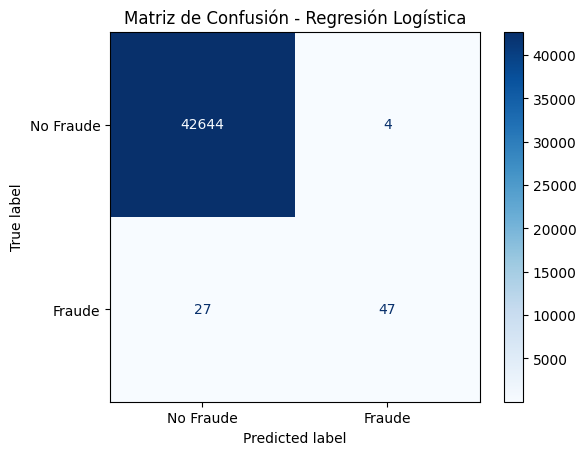

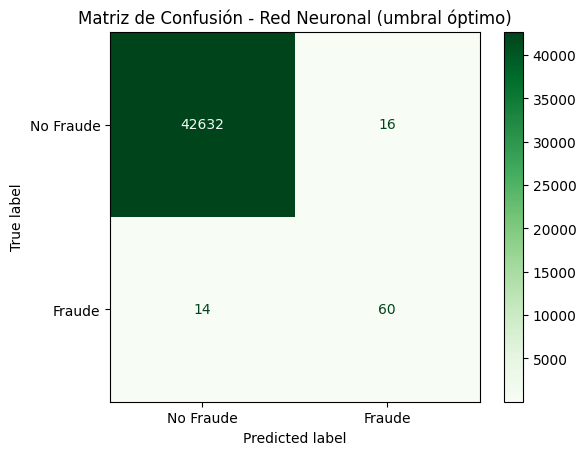

,Accuracy,Precision,Recall,F1-score,AUC
Modelo,,,,,
Regresión Logística,0.9993,0.9216,0.6351,0.752,0.9565
Red Neuronal,0.9993,0.7895,0.8108,0.800,0.9751


In [8]:
# 7. Metricas de modelos
# Matrices de confusión
plot_confusion_matrix(y_test, y_pred_log, model_name="Regresión Logística", cmap="Blues")
plot_confusion_matrix(y_test, y_pred_nn_best, model_name="Red Neuronal (umbral óptimo)", cmap="Greens")

# Tabla de métricas
df_metrics = get_classification_metrics_df(
    y_test, y_pred_log, y_prob_log,
    y_test, y_pred_nn_best, y_prob_nn
)
display(df_metrics)

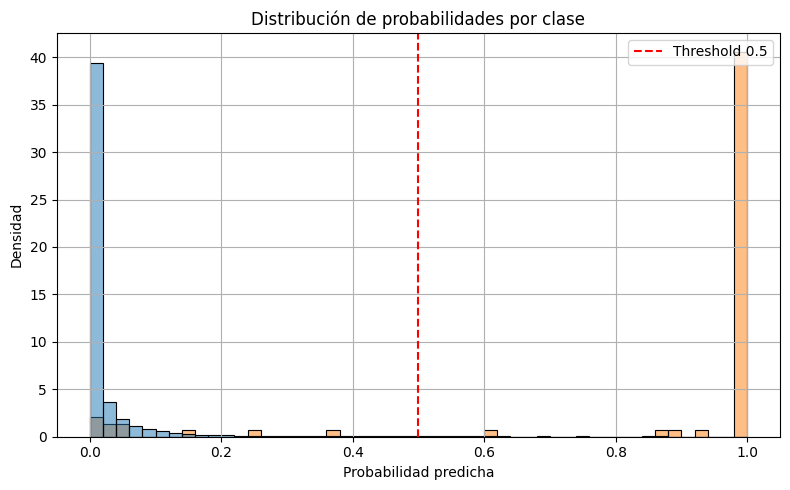

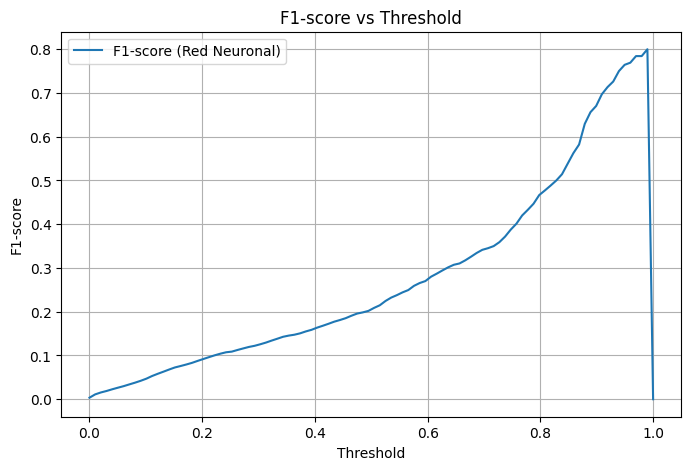

In [9]:
# 9a. Distribución de predicciones para NN
plot_prediction_distribution(y_test, y_prob_nn)
plot_f1_vs_threshold(y_test, y_prob_nn, modelo="Red Neuronal")  

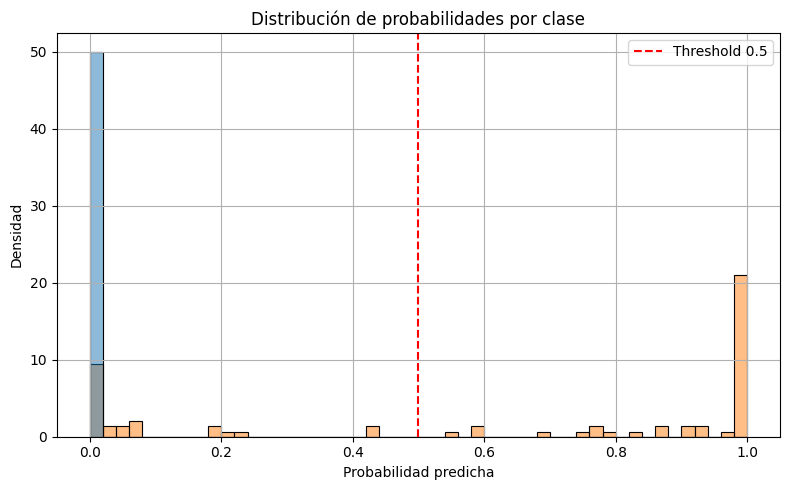

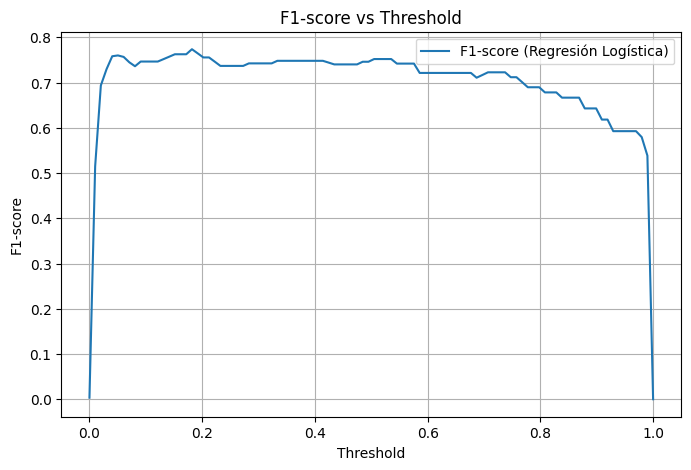

In [10]:
# 9b. Distribución de predicciones para Regresión Logística
plot_prediction_distribution(y_test, y_prob_log)
plot_f1_vs_threshold(y_test, y_prob_log, modelo="Regresión Logística")

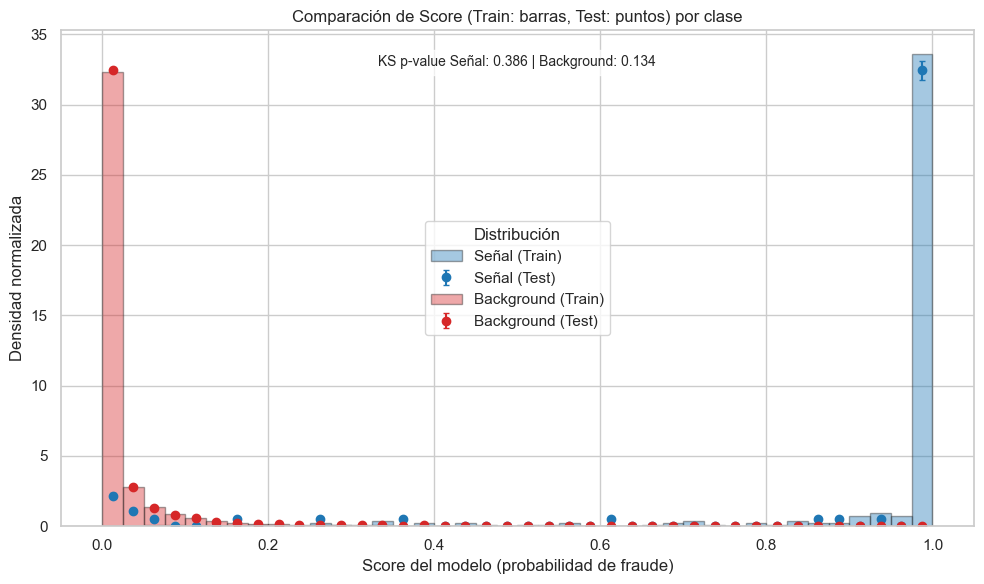

In [11]:
# 10. Evaluación de sobreajuste en la red neuronal
plot_ks_overtraining(y_train, y_prob_train_nn, y_test, y_prob_nn)